In [164]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix
)
from scipy.stats import spearmanr


In [165]:
# ===============================================================
# COACH CHANGE PREDICTION — DATA PREPARATION
# ===============================================================

# Load Data
coaches = pd.read_csv("data/coaches.csv")
teams = pd.read_csv("data/teams.csv")
awards_players = pd.read_csv("data/awards_players.csv")

# Add info about next year's coach (target variable)
coaches["next_coachID"] = coaches.groupby("tmID")["coachID"].shift(-1)
coaches["coach_changed_next_year"] = (coaches["coachID"] != coaches["next_coachID"]).astype(int)


# Compute win ratio
coaches["win_ratio"] = np.where(
    (coaches["post_wins"] == 0) & (coaches["post_losses"] == 0),
    coaches["won"] / (coaches["won"] + coaches["lost"]),
    (coaches["won"] + coaches["post_wins"]) /
    (coaches["won"] + coaches["lost"] + coaches["post_wins"] + coaches["post_losses"])
)

# Ensure correct order before applying cumulative stats
coaches = coaches.sort_values(["coachID", "year"]).reset_index(drop=True)


# Compute Cumulative Win Ratio
def compute_cumulative_win_ratio(group):
    group = group.copy()
    group["cumulative_win_ratio"] = 0.0
    for i in range(len(group)):
        if i == 0:
            group.loc[group.index[i], "cumulative_win_ratio"] = group.loc[group.index[i], "win_ratio"]
        else:
            prev = group.loc[group.index[i - 1], "cumulative_win_ratio"]
            curr = group.loc[group.index[i], "win_ratio"]
            # simple weighted smoothing (50/50)
            group.loc[group.index[i], "cumulative_win_ratio"] = 0.5 * curr + 0.5 * prev
    # shift so each season uses only past cumulative performance
    group["cumulative_win_ratio"] = group["cumulative_win_ratio"].shift(1)
    return group

# Apply per coach
coaches = coaches.groupby("coachID", group_keys=False).apply(compute_cumulative_win_ratio)

# Fill NaNs for rookie coaches (no prior data)
avg_cumulative_win_ratio = coaches["cumulative_win_ratio"].mean(skipna=True)
coaches["cumulative_win_ratio"] = coaches["cumulative_win_ratio"].fillna(avg_cumulative_win_ratio)


# Previous season win ratio - teams
coaches["team_win_ratio"] = coaches.groupby("tmID")["win_ratio"].shift(1)

# 3-year rolling average of win ratio (performance trend)
coaches["3yr_win_ratio"] = (
    coaches.groupby("tmID")["team_win_ratio"]
    .rolling(window=3, min_periods=1)
    .mean()
    .reset_index(level=0, drop=True)
)

# Expectation gap (current vs. recent average)
coaches["expectation_gap"] = coaches["team_win_ratio"] - coaches["3yr_win_ratio"]



# Filter only "Coach of the Year" awards
coach_awards = awards_players[awards_players["award"] == "Coach of the Year"]
# Compute number of times each coach won
coach_award_count = (
    coach_awards.groupby("playerID")
    .size()
    .reset_index(name="coach_award_count")
)

# Merge into your main coach dataframe
coaches = coaches.merge(
    coach_award_count.rename(columns={"playerID": "coachID"}),
    on="coachID",
    how="left"
)

# Replace NaN with 0 for coaches with no awards
coaches["coach_award_count"] = coaches["coach_award_count"].fillna(0)




# Team stability index (how often the team fires coaches)
coaches["team_stability_index"] = (
    coaches.groupby("tmID")["coach_changed_next_year"]
    .shift(1)  # only use previous seasons
    .rolling(3, min_periods=1)
    .mean()
    .reset_index(level=0, drop=True)
)


# Years with team (coach tenure)
coaches = coaches.sort_values(["coachID", "tmID", "stint", "year"])
coaches["years_with_team_stint"] = (
    coaches.groupby(["coachID", "tmID", "stint"]).cumcount() + 1
)

#'''
# merge teams info into coaches so each coach row has that season's team info
coaches = coaches.merge(
    teams[["year", "tmID", "rank", "playoff"]],
    on=["year", "tmID"],
    how="left",
    validate="m:1"   
)

coaches = coaches.sort_values(["tmID", "year"]).reset_index(drop=True)

coaches["team_prev_rank"] = coaches.groupby("tmID")["rank"].shift(1)
coaches["team_prev_playoff"] = coaches.groupby("tmID")["playoff"].shift(1).map({"Y": 1, "N": 0})


# Playoff miss streak
def playoff_streak(series):
    streaks = []
    streak = 0
    for made in series:
        if made == 0:
            streak += 1
        else:
            streak = 0
        streaks.append(streak)
    return streaks

coaches["playoff_miss_streak"] = coaches.groupby("tmID")["team_prev_playoff"].transform(playoff_streak)

#'''

coaches = coaches.drop(columns=["lgID", "stint", "won", "lost", "post_wins", "post_losses", "win_ratio"])

coaches = coaches.sort_values(["tmID", "year"]).reset_index(drop=True)
coaches_year = coaches[coaches["year"] == 9]
coaches_year.head(20)

/tmp/ipykernel_12329/1619676852.py:44: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  coaches = coaches.groupby("coachID", group_keys=False).apply(compute_cumulative_win_ratio)


,coachID,year,tmID,next_coachID,coach_changed_next_year,cumulative_win_ratio,team_win_ratio,3yr_win_ratio,expectation_gap,coach_award_count,team_stability_index,years_with_team_stint,rank,playoff,team_prev_rank,team_prev_playoff,playoff_miss_streak
0,meadoma99w,9,ATL,meadoma99w,0,0.519859,NaN,NaN,NaN,1.0,0.000000,1,7,N,NaN,NaN,0
12,keyst99wc,9,CHI,keyst99wc,0,0.519859,0.147059,0.147059,0.000000,0.0,1.000000,1,5,N,6.0,0.0,2
23,thibami99w,9,CON,thibami99w,0,0.602037,0.513514,0.665066,-0.151553,2.0,0.000000,6,2,Y,3.0,1.0,0
34,laimbbi01w,9,DET,laimbbi01w,0,0.625598,0.666667,0.597643,0.069024,1.0,0.000000,6,1,Y,1.0,1.0,0
45,thompka99w,9,HOU,NaN,1,0.544118,0.382353,0.473605,-0.091252,0.0,0.666667,2,5,N,5.0,0.0,1
54,dunnli99wc,9,IND,dunnli99wc,0,0.375000,0.281250,0.281250,0.000000,0.0,0.333333,1,4,Y,2.0,1.0,0
67,coopemi01w,9,LAS,coopemi01w,0,0.510633,0.294118,0.556179,-0.262061,1.0,0.000000,6,3,Y,7.0,0.0,1
82,zierddo99w,9,MIN,NaN,1,0.294118,0.294118,0.331038,-0.036920,0.0,0.333333,2,7,N,6.0,0.0,4
93,coylepa99w,9,NYL,coylepa99w,0,0.443764,0.459459,0.427663,0.031797,0.0,0.000000,4,3,Y,4.0,1.0,0
108,gaineco01w,9,PHO,gaineco01w,0,0.519859,0.600000,0.503125,0.096875,0.0,0.333333,1,6,N,1.0,1.0,0


Treino: (146, 17) | Teste (10): (16, 17)

Evaluation for year 10:
Accuracy:  0.688
Precision: 1.000
Recall:    0.688
F1-score:  0.815
Spearman: nan (p=nan)

🏀 Top predicted coach changes (with actual result):
     year     coachID  pred_proba  predicted_change  coach_changed_next_year
13     10   keyst99wc    0.838066                 1                        1
94     10  coylepa99w    0.655691                 1                        1
161    10  plankju99w    0.591071                 1                        1
55     10  dunnli99wc    0.574651                 1                        1
83     10  gilloje01w    0.559398                 1                        1
68     10  coopemi01w    0.540394                 1                        1
95     10  donovan99w    0.534783                 1                        1
36     10  mahorri01w    0.533999                 1                        1
124    10  bouceje01w    0.497211                 1                        1
144    10  aglerbr99w

/tmp/ipykernel_12329/1372746065.py:50: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_corr, spearman_p = spearmanr(y_test, test_data["pred_proba"])


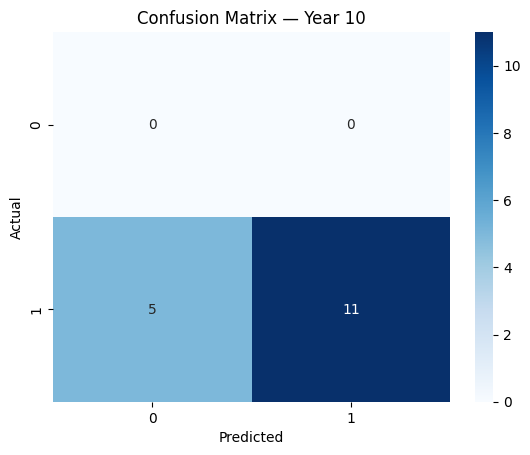

/tmp/ipykernel_12329/1372746065.py:94: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance, x="Importance", y="Feature", palette="viridis")


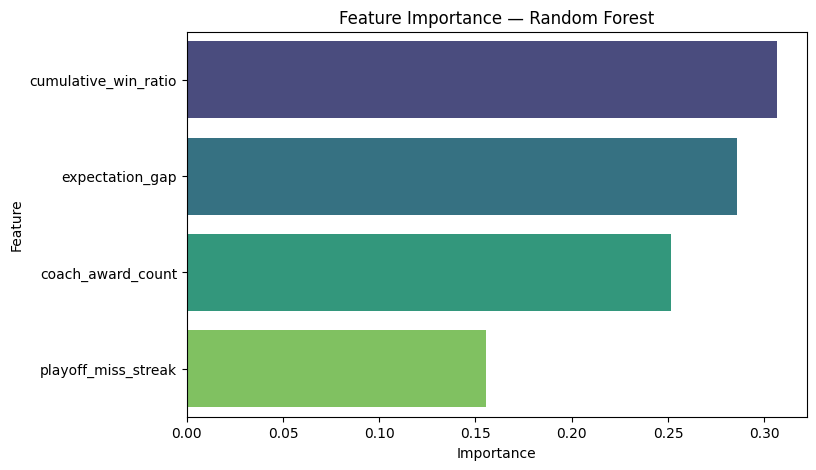


Feature Influence (higher = more impact on firing prediction):
                Feature  Importance
1  cumulative_win_ratio    0.306795
0       expectation_gap    0.285925
2     coach_award_count    0.251577
3   playoff_miss_streak    0.155704


In [170]:
# ===============================================================
# COACH CHANGE PREDICTION — MODEL & EVALUATION
# ===============================================================

target_year = 10
train_data = coaches[coaches["year"] < target_year]
test_data  = coaches[coaches["year"] == target_year]

print(f"Treino: {train_data.shape} | Teste ({target_year}): {test_data.shape}")

# Define features and target

features = [
    "expectation_gap"
    ,"cumulative_win_ratio"
    ,"coach_award_count"
    #,"years_with_team_stint"  
    #,"team_stability_index"
    ,"playoff_miss_streak"  
]
target = "coach_changed_next_year"

X_train = train_data[features]
y_train = train_data[target]
X_test = test_data[features]
y_test = test_data[target]

model = RandomForestClassifier(
    n_estimators=200,
    max_depth=5,
    random_state=42,
    class_weight="balanced"
)
model.fit(X_train, y_train)


# Predictions

test_data = test_data.copy()
test_data.loc[:, "pred_proba"] = model.predict_proba(X_test)[:, 1]

threshold = 0.4
test_data.loc[:, "predicted_change"] = (test_data["pred_proba"] > threshold).astype(int)


acc = accuracy_score(y_test, test_data["predicted_change"])
prec = precision_score(y_test, test_data["predicted_change"])
rec = recall_score(y_test, test_data["predicted_change"])
f1 = f1_score(y_test, test_data["predicted_change"])
spearman_corr, spearman_p = spearmanr(y_test, test_data["pred_proba"])

print(f"\nEvaluation for year {target_year}:")
print(f"Accuracy:  {acc:.3f}")
print(f"Precision: {prec:.3f}")
print(f"Recall:    {rec:.3f}")
print(f"F1-score:  {f1:.3f}")
print(f"Spearman: {spearman_corr:.3f} (p={spearman_p:.3f})")

print("\n🏀 Top predicted coach changes (with actual result):")
print(
    test_data[[
        "year", "coachID", "pred_proba",
        "predicted_change", "coach_changed_next_year"
    ]]
    .sort_values("pred_proba", ascending=False)
    .head(20)
)

# Evaluation


# Confusion Matrix

# Column [0]: probability of class 0: coach stays

# Column [1]: probability of class 1: coach changes/fired


cm = confusion_matrix(y_test, test_data["predicted_change"])
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title(f"Confusion Matrix — Year {target_year}")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Feature Importance

importance = pd.DataFrame({
    "Feature": features,
    "Importance": model.feature_importances_
}).sort_values("Importance", ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(data=importance, x="Importance", y="Feature", palette="viridis")
plt.title("Feature Importance — Random Forest")
plt.show()

print("\nFeature Influence (higher = more impact on firing prediction):")
print(importance)
